In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:

GAUSSIAN_SMOOTH_FILTER_SIZE = (3, 3)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9
def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # tạo bộ lọc kernel

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement,
                                 iterations=10)

    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement,
                                   iterations=10)  # Nổi bật chi tiết tối trong nền sáng

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)


    return imgGrayscalePlusTopHatMinusBlackHat


In [ ]:
import math
def Hough_transform(threshold_image, nol=4):

    h, w = threshold_image.shape[:2]
    temp = threshold_image.copy()
    linesP = cv2.HoughLinesP(temp, 1, np.pi / 180, 50, None, 50, 1)
    dist = []
    if linesP is None:
      return None
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        d = math.sqrt((l[0] - l[2]) ** 2 + (l[1] - l[3]) ** 2)
        if d < 0.65 * max(h, w) or d>=0.9 * max(h,w):
          d = 0
        dist.append(d)
    dist = np.array(dist).reshape(-1, 1, 1)
    linesP = np.concatenate([linesP, dist], axis=2)
    linesP = sorted(linesP, key=lambda x: x[0][-1], reverse=True)[:nol]
    return linesP
def closing(img,size):
  kernel = np.ones((size, size), np.uint8)
  res = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  return res

def rotate_LP(img, angle):

    height, width = img.shape[:2]
    ptPlateCenter = width / 2, height / 2
    rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, -angle, 1.0)
    rotated_img = cv2.warpAffine(img, rotationMatrix, (width, height))
    return rotated_img
def weighted_average(numbers):
    total = 0
    weight_sum = 0

    for number in numbers:
        absolute_value = abs(number)
        weight = 1
        if absolute_value > 0:
            weight = absolute_value

        total += number * weight
        weight_sum += weight



    return float(total / weight_sum)

def rotation_angle(linesP,imgOriginal):

    img_cop = imgOriginal.copy()
    angles = []
    for i in range(0, len(linesP)):
        l = linesP[i][0].astype(int)
        p1 = (l[0], l[1])
        p2 = (l[2], l[3])
        doi = (l[1] - l[3])
        ke = abs(l[0] - l[2])
        angle = math.atan(doi / ke) * (180.0 / math.pi)
        if abs(angle) > 45:
            angle = (90 - abs(angle)) * angle / abs(angle)
        angles.append(angle)


    angles = list(filter(lambda x: (abs(x > -10) and abs(x < 15)), angles))

    if not angles:
        angles = list([0])
    angle = weighted_average(np.array(angles))
    return angle

def dilation_1(img,size):
  kernel = np.ones((size,size), np.uint8)
  dilated_image = cv2.dilate(img, kernel, cv2.BORDER_CONSTANT,iterations= 1)

  return dilated_image

def license_plate_recognition_1(binary_image,previous_end,alpha=7, beta=8):
    num_rows, num_cols = binary_image.shape
    start_row = None
    end_row = None
    region_found = False
    for i in range(previous_end,num_rows):


      row = binary_image[i, :]
      num_changes = sum((row[:-1] != row[1:]).astype(int))

      if num_changes >= alpha:
        if start_row is None:
          start_row = i
        elif i - start_row >= beta:
          end_row = i
          region_found = True
          break

    if region_found:

        return start_row, end_row
    else:
        return None,None

def preprocess3(imgOriginal):
  res = cv2.cvtColor(imgOriginal,cv2.COLOR_BGR2GRAY)

  res = maximizeContrast(res)
  res = cv2.bilateralFilter(res,10,150,130)

  _, res = cv2.threshold(res  , 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


  res = cv2.Canny(res, 250, 255)
  kernel = np.ones((3, 3), np.uint8)
  res = cv2.dilate(res, kernel, iterations=1)



  return res
def connected_labels_with_components(threshImg,num_connectivity=4):
  weight_r = int(0*threshImg.shape[1])
  weight_c = int(0*threshImg.shape[0])
  temp = threshImg.copy()[weight_c:threshImg.shape[0]-weight_c,weight_r:threshImg.shape[1]-weight_r]

  totalLabels, labels, stats, centroid=  cv2.connectedComponentsWithStats(threshImg, num_connectivity, cv2.CV_32S)
  return totalLabels, labels, stats, centroid

def erosion(image, kernel_size=2, iterations=1):

    kernel = np.ones((kernel_size, kernel_size), np.uint8)


    result = cv2.erode(image, kernel, iterations=iterations)

    return result

def dilate(image, kernel_size=2, iterations=1):

    kernel = np.ones((kernel_size, kernel_size), np.uint8)


    result = cv2.dilate(image, kernel, iterations=iterations)

    return result


def crop_license_plate(img):



    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    _, thresh = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    max_contour = max(contours, key=cv2.contourArea)


    x, y, w, h = cv2.boundingRect(max_contour)
    return x,y,w,h

from skimage.filters import threshold_local
def preprocess8(image,blocksize = 35,offset=5):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  T = threshold_local(gray,33, offset=15, method="gaussian") # 33,15
  thresh = (gray > T).astype("uint8") * 255
  thresh = cv2.bitwise_not(thresh)
  thresh = imutils.resize(thresh, width=600)
  thresh = cv2.medianBlur(thresh,15) #15
  return thresh

In [ ]:
index_to_class = {0: '0',1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',8: '8',9: '9',10: 'A',11: 'B',12: 'C',13: 'D',14: 'E',15: 'F',16: 'G',17: 'H',18: 'K',
 19: 'L',
 20: 'M',
 21: 'N',
 22: 'P',
 23: 'R',
 24: 'S',
 25: 'T',
 26: 'U',
 27: 'V',
 28: 'X',
 29: 'Y',
 30: 'Z'}

In [ ]:
import imutils
from imutils import perspective
def detection_regconition_with_cnn(img,index_to_class,model_detect_frame,cnn_model):
  LpRegion = img.copy()
  cropped_LP_copy = LpRegion
  cropped_LP_copy = cv2.resize(cropped_LP_copy,(200,127),interpolation=cv2.INTER_AREA)
  rotated_LP = preprocess3(cropped_LP_copy)
  linesP = Hough_transform(rotated_LP,1)
  angle = 0
  if linesP is not None:
    for i in range(0, len(linesP)):
      l = linesP[i][0].astype(int)
    angle = rotation_angle(linesP,cropped_LP_copy)
  LpRegion_rotated = rotate_LP(LpRegion, angle)

  x,y,w,h = crop_license_plate(LpRegion_rotated)
  thresh_drop_border = LpRegion_rotated[y:y+h,x:x+w]



  thresh_drop_border = thresh_drop_border
  thresh = preprocess8(thresh_drop_border)
  kernel = np.ones(5, np.uint8)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

  thresh = cv2.resize(thresh,(200,100))
  _, labels = cv2.connectedComponents(thresh)
  mask = np.zeros(thresh.shape, dtype="uint8")
  total_pixels = thresh.shape[0] * thresh.shape[1]
  lower = total_pixels // 120
  upper = total_pixels // 20
  for label in np.unique(labels):
    if label == 0:
      continue
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    if numPixels > lower and numPixels < upper:
      mask = cv2.add(mask, labelMask)
  cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  boundingBoxes = [cv2.boundingRect(c) for c in cnts]
  boundingBoxes = np.array(boundingBoxes)
  mean_w = np.mean(boundingBoxes[:, 2])
  mean_h = np.mean(boundingBoxes[:, 3])
  mean_y = np.mean(boundingBoxes[:,1])
  threshold_w = mean_w * 1.5
  threshold_h = mean_h * 1.5
  new_boundingBoxes = boundingBoxes[(boundingBoxes[:, 2] < threshold_w) & (boundingBoxes[:, 3] < threshold_h)]
  line1 = []
  line2 = []
  for box in new_boundingBoxes:
      x,y,w,h  =box
      if y > mean_y * 1.2:
          line2.append(box)
      else:
          line1.append(box)

  line1 = sorted(line1, key=lambda box: box[0])
  line2 = sorted(line2, key=lambda box: box[0])
  boundingBoxes = line1+line2
  img_with_boxes = imutils.resize(img.copy(), width=600)
  image = imutils.resize(img.copy(), width=600)
  characters_digits = []
  for bbox in boundingBoxes:
      x, y, w, h = bbox
      character = mask[y:y+h,x:x+w]

      if x>=3 and x<=170  and h>=20 and h<= 55 and y>=2 and h>=w:

        character = cv2.cvtColor(character, cv2.COLOR_GRAY2BGR)
        character = cv2.resize(character, (32, 32),interpolation=cv2.INTER_AREA)
        img_reshaped = np.expand_dims(character,axis=0)
        img_reshaped = img_reshaped / 255.0
        pred = cnn_model.predict(img_reshaped,verbose = 0)
        lb = index_to_class[np.argmax(pred[0])]

        characters_digits.append(lb)
  characters_digits = ''.join(characters_digits)
  return characters_digits


def detection_regconition_with_svm(img,model_detect_frame,svm_model):
  LpRegion = img
  cropped_LP_copy = LpRegion

  cropped_LP_copy = cv2.resize(cropped_LP_copy,(200,127),interpolation=cv2.INTER_AREA)
  rotated_LP = preprocess3(cropped_LP_copy)
  linesP = Hough_transform(rotated_LP,1)
  angle = 0
  if linesP is not None:
    for i in range(0, len(linesP)):
      l = linesP[i][0].astype(int)
    angle = rotation_angle(linesP,cropped_LP_copy)
  LpRegion_rotated = rotate_LP(LpRegion, angle)
  LpRegion_rotated_2 = rotate_LP(img, angle)
  x,y,w,h = crop_license_plate(LpRegion_rotated)
  thresh_drop_border = LpRegion_rotated[y:y+h,x:x+w]
  height, width = thresh_drop_border.shape[:2]


  thresh_drop_border = thresh_drop_border
  thresh = preprocess8(thresh_drop_border)
  kernel = np.ones(5, np.uint8)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

  thresh = cv2.resize(thresh,(200,100))

  _, labels = cv2.connectedComponents(thresh)
  mask = np.zeros(thresh.shape, dtype="uint8")
  total_pixels = thresh.shape[0] * thresh.shape[1]
  lower = total_pixels // 120
  upper = total_pixels // 20
  for label in np.unique(labels):
    if label == 0:
      continue
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    if numPixels > lower and numPixels < upper:
      mask = cv2.add(mask, labelMask)
  cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  boundingBoxes = [cv2.boundingRect(c) for c in cnts]
  boundingBoxes = np.array(boundingBoxes)
  mean_w = np.mean(boundingBoxes[:, 2])
  mean_h = np.mean(boundingBoxes[:, 3])
  mean_y = np.mean(boundingBoxes[:,1])
  threshold_w = mean_w * 1.5
  threshold_h = mean_h * 1.5
  new_boundingBoxes = boundingBoxes[(boundingBoxes[:, 2] < threshold_w) & (boundingBoxes[:, 3] < threshold_h)]
  line1 = []
  line2 = []
  for box in new_boundingBoxes:
      x,y,w,h  =box
      if y > mean_y * 1.2:
          line2.append(box)
      else:
          line1.append(box)

  line1 = sorted(line1, key=lambda box: box[0])
  line2 = sorted(line2, key=lambda box: box[0])
  boundingBoxes = line1+line2
  img_with_boxes = imutils.resize(img.copy(), width=600)
  image = imutils.resize(img.copy(), width=600)

  characters_digits = []
  for bbox in boundingBoxes:
      x, y, w, h = bbox
      character = mask[y:y+h,x:x+w]

      if x>=3 and x<=170  and h>=20 and h<= 55:

        character = cv2.cvtColor(character, cv2.COLOR_GRAY2BGR)
        character = cv2.resize(character, (20, 20),interpolation=cv2.INTER_AREA)
        character = np.array(character)
        character = character.reshape(-1)
        character = np.expand_dims(character,axis = 0)
        pred = svm_model.predict(character)
        characters_digits.append(pred[0])
  characters_digits = ''.join(characters_digits)
  return characters_digits



def detection_regconition_with_softmax(img,model_detect_frame,softmax_model):
  LpRegion = img
  cropped_LP_copy = LpRegion
  cropped_LP_copy = cv2.resize(cropped_LP_copy,(200,127),interpolation=cv2.INTER_AREA)
  rotated_LP = preprocess3(cropped_LP_copy)
  linesP = Hough_transform(rotated_LP,1)
  angle = 0
  if linesP is not None:
    for i in range(0, len(linesP)):
      l = linesP[i][0].astype(int)
    angle = rotation_angle(linesP,cropped_LP_copy)
  LpRegion_rotated = rotate_LP(LpRegion, angle)
  x,y,w,h = crop_license_plate(LpRegion_rotated)
  thresh_drop_border = LpRegion_rotated[y:y+h,x:x+w]


  thresh_drop_border = thresh_drop_border
  thresh = preprocess8(thresh_drop_border)
  kernel = np.ones(5, np.uint8)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

  thresh = cv2.resize(thresh,(200,100))

  _, labels = cv2.connectedComponents(thresh)
  mask = np.zeros(thresh.shape, dtype="uint8")
  total_pixels = thresh.shape[0] * thresh.shape[1]
  lower = total_pixels // 90
  upper = total_pixels // 20
  for label in np.unique(labels):
    if label == 0:
      continue
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    if numPixels > lower and numPixels < upper:
      mask = cv2.add(mask, labelMask)
  cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  boundingBoxes = [cv2.boundingRect(c) for c in cnts]
  boundingBoxes = np.array(boundingBoxes)
  mean_w = np.mean(boundingBoxes[:, 2])
  mean_h = np.mean(boundingBoxes[:, 3])
  mean_y = np.mean(boundingBoxes[:,1])
  threshold_w = mean_w * 1.5
  threshold_h = mean_h * 1.5
  new_boundingBoxes = boundingBoxes[(boundingBoxes[:, 2] < threshold_w) & (boundingBoxes[:, 3] < threshold_h)]
  line1 = []
  line2 = []
  for box in new_boundingBoxes:
      x,y,w,h  =box
      if x>=3 and x<=170  and h>=20 and h<= 55 and y>=2 and h>=w:
        if y > mean_y * 1.2:
          line2.append(box)
        else:
          line1.append(box)

  line1 = sorted(line1, key=lambda box: box[0])
  line2 = sorted(line2, key=lambda box: box[0])
  boundingBoxes = line1+line2
  img_with_boxes = imutils.resize(img.copy(), width=600)
  image = imutils.resize(img.copy(), width=600)

  characters_digits = []
  for bbox in boundingBoxes:
      x, y, w, h = bbox
      character = mask[y:y+h,x:x+w]

      character = cv2.cvtColor(character, cv2.COLOR_GRAY2BGR)
      character = cv2.resize(character, (20, 20),interpolation=cv2.INTER_AREA)
      character = np.array(character)
      character = character.reshape(-1)
      character = np.expand_dims(character,axis = 0)
      pred = softmax_model.predict(character)
      characters_digits.append((pred[0]))
  characters_digits = ''.join(characters_digits)
  return characters_digits

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass
def cnn_model(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(31, activation='softmax'))

    return model

model = cnn_model()
model.summary()

model.load_weights('/content/gdrive/MyDrive/Đồ án/CS231/CNN.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                   

In [ ]:
import pickle
svm=pickle.load(open("/content/gdrive/MyDrive/Đồ án/Xử lý ảnh + Nhập môn CV/svm_10_12.yml","rb"))
softmax=pickle.load(open("/content/gdrive/MyDrive/Đồ án/Xử lý ảnh + Nhập môn CV/softmax_10_12.yml","rb"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
folder_path = '/content/gdrive/MyDrive/Đồ án/Xử lý ảnh + Nhập môn CV/data_new_modified'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0
)

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
model_detect_frame = YOLO('/content/gdrive/MyDrive/Đồ án/Xử lý ảnh + Nhập môn CV/YOLOV8_NHAPMONCV.pt')

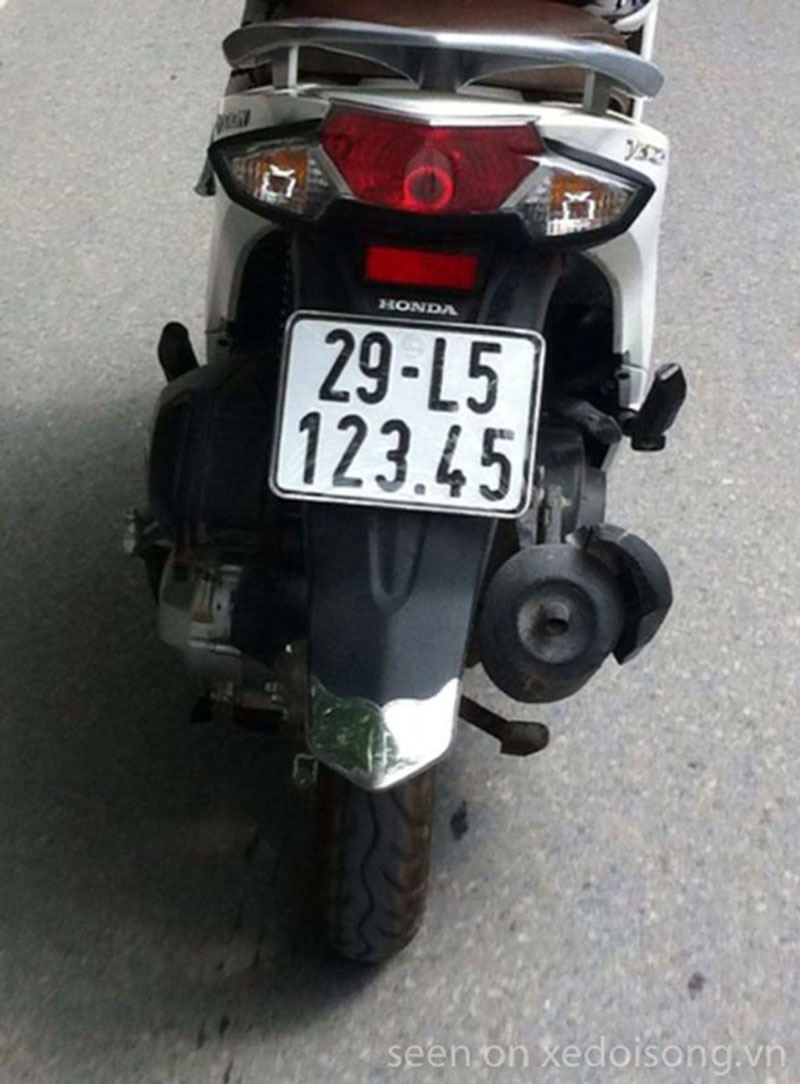


0: 640x480 1 0, 609.6ms
Speed: 4.9ms preprocess, 609.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


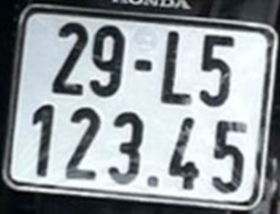

YOLOV8 + CNN predict:  29L512345
YOLOV8 + SVM predict:  29L512345
YOLOV8 + SOFTMAX predict:  29L512345


In [ ]:
from google.colab import drive
from urllib.request import urlopen

image_url = "https://i.vietgiaitri.com/2019/9/3/tan-muc-dan-xe-honda-vision-bien-so-sieu-dep-e45275.jpg"
resp = urlopen(image_url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(image, cv2.IMREAD_COLOR)

cv2_imshow(img)
results = model_detect_frame(img)
LpRegion_input = 0

for result in results:
  boxes = result.boxes.xyxy
  for box in boxes:
    xmin, ymin, xmax, ymax = box
    coord = np.array([[xmin, ymin], [xmax, ymin], [xmin, ymax], [xmax,ymax]])
    img_2 = img.copy()
    cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 6)
    LpRegion_input = perspective.four_point_transform(img_2, coord)
    break
cv2_imshow(LpRegion_input)
res_1 = detection_regconition_with_cnn(LpRegion_input,index_to_class,model_detect_frame,model)
res_2 = detection_regconition_with_svm(LpRegion_input,model_detect_frame,svm)
res_3 = detection_regconition_with_softmax(LpRegion_input,model_detect_frame,softmax)
print("YOLOV8 + CNN predict: ",res_1)
print("YOLOV8 + SVM predict: ",res_2)
print("YOLOV8 + SOFTMAX predict: ",res_3)